# Time series forecasting

Ausgrid is one of the major electricity distributors in Australia. The company plays a crucial role in managing and distributing electricity to residential, commercial, and industrial consumers within its service area.
The challenge is to develop a robust forecasting model that can predict energy consumption. The prediction ensures a proper control of the energy that will be supplied to the users resulting in optimal energy management.  


## Set up Google Cloud Environment

In [ ]:

# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [2]:
PROJECT_ID = "silver-stratum-418405"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}
REGION = "us-central1"

Updated property [core/project].


In [8]:
# Authenticate Google Cloud Account
! gcloud config set account "68133805090-compute@developer.gserviceaccount.com"
#! gcloud auth login

Updated property [core/account].


In [18]:
# Get the source dataset from GCS
! gsutil cp gs://silver-stratum-bucket/SolarMonthlyData_2657Custs.csv .

Copying gs://silver-stratum-bucket/SolarMonthlyData_2657Custs.csv...
- [1 files][ 36.1 MiB/ 36.1 MiB]                                                
Operation completed over 1 objects/36.1 MiB.                                     


In [19]:
# Get the source dataset from GCS
! gsutil cp gs://silver-stratum-bucket/NonSolarMonthlyData_4064Custs.csv .

Copying gs://silver-stratum-bucket/NonSolarMonthlyData_4064Custs.csv...
/ [1 files][ 30.1 MiB/ 30.1 MiB]                                                
Operation completed over 1 objects/30.1 MiB.                                     


## Multi-series modeling

Multi-Series Modeling (Global Forecasting Model) involves building a single predictive model that considers multiple time series simultaneously. It attempts to capture the core patterns that govern the series, thereby mitigating the potential noise that each series might introduce.

### Independent multi-series forecasting

In independent multi-series forecasting, a single model is trained on all time series, but each remains independent of the others, meaning that past values of one series are not used as predictors of other series. 

In [12]:
! pip3 install skforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.3/558.3 kB 7.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.7 MB/s eta 0:00:00


In [1]:
# Libraries
# ======================================================================================
import sys
import os
import datetime as dt
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import  HistGradientBoostingRegressor
import skforecast
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
warnings.filterwarnings('once')
%matplotlib inline 

print(f"Version skforecasy: {skforecast.__version__}")
print(f"Version scikit-learn: {sklearn.__version__}")

Version skforecasy: 0.12.0
Version scikit-learn: 1.4.2


In [2]:
# Data loading
# ======================================================================================
solar_data = pd.read_csv('./SolarMonthlyData_2657Custs.csv')
display(solar_data)
print(f"Shape: {solar_data.shape}")

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me
0,1,SC,1.2007,31.000,DAY
1,1,SC,1.2008,31.000,DAY
2,1,SC,1.2009,31.000,DAY
3,1,SC,1.2010,31.000,DAY
4,1,PK,1.2011,31.000,DAY
...,...,...,...,...,...
1378649,2768,SGR,12.2014,254.409,KWH
1378650,2768,PK,12.2014,52.251,KWH
1378651,2768,PGR,12.2014,104.164,KWH
1378652,2768,OP,12.2014,104.630,KWH


Shape: (1378654, 5)


In [3]:
# Data preprocessing
# ======================================================================================
consumption_billrate = ['PK', 'LVP', 'SH', 'LVS','OP','OP1','OP2']
solar_data_consumption = solar_data[(solar_data['Netwk Bill Rate Type'].isin(consumption_billrate)) & (solar_data['Unit of me'] == 'KWH')].copy()
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
solar_data_consumption['Consumption Month'] = solar_data_consumption['Consumption Month'].astype('str')
solar_data_consumption['Consumption Month'] = pd.to_datetime(solar_data_consumption['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
#solar_data_consumption['house_type'] = 'solar'
solar_data_consumption.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me,house_type
96,1,OP1,2007-01-01,168.073,KWH,solar
97,1,OP1,2008-01-01,145.746,KWH,solar
99,1,OP1,2009-01-01,189.888,KWH,solar
101,1,OP1,2010-01-01,163.563,KWH,solar
103,1,OP1,2011-01-01,176.308,KWH,solar


In [4]:
generation_billrate = ['PGR', 'SGR','OGR','OGG','PGG','SGG']
solar_data_generation = solar_data[(solar_data['Netwk Bill Rate Type'].isin(generation_billrate)) & (solar_data['Unit of me'] == 'KWH')].copy()
solar_data_generation['Consumption Month'] = solar_data_generation['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
solar_data_generation['Consumption Month'] = solar_data_generation['Consumption Month'].astype('str')
solar_data_generation['Consumption Month'] = pd.to_datetime(solar_data_generation['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
#solar_data_generation['house_type'] = 'solar'
solar_data_generation.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me,house_type
104,1,OGR,2011-01-01,2.060,KWH,solar
107,1,SGR,2011-01-01,411.840,KWH,solar
109,1,PGR,2011-01-01,131.230,KWH,solar
113,1,OGR,2012-01-01,2.031,KWH,solar
115,1,PGR,2012-01-01,116.147,KWH,solar


In [6]:
solar_gross_consumption = solar_data_consumption.groupby(['Customer ID', 'Consumption Month']).agg(consumption = ('Sum','sum'))
solar_gross_consumption.head()

consumption
Customer ID Consumption Month             
1           2007-01-01             168.073
            2007-02-01             159.667
            2007-03-01             176.774
            2007-04-01             182.439
            2007-05-01             235.507

In [24]:
solar_gross_generation = solar_data_generation.groupby(['Customer ID', 'Consumption Month']).agg(consumption = ('Sum','sum')).reset_index()
solar_gross_generation.head()

,Customer ID,Consumption Month,consumption
0,1,2010-05-01,122.796
1,1,2010-06-01,245.592
2,1,2010-07-01,276.115
3,1,2010-08-01,426.897
4,1,2010-09-01,413.127


In [25]:
solar_net_consumption = solar_gross_consumption.merge(solar_gross_generation, on = ['Customer ID', 'Consumption Month'], how = 'left',
          suffixes=('_left', '_right'))
solar_net_consumption.head()

,Customer ID,Consumption Month,consumption_left,consumption_right
0,1,2007-01-01,168.073,NaN
1,1,2007-02-01,159.667,NaN
2,1,2007-03-01,176.774,NaN
3,1,2007-04-01,182.439,NaN
4,1,2007-05-01,235.507,NaN


In [26]:
solar_net_consumption['consumption'] = solar_net_consumption.fillna(0)['consumption_left'] - solar_net_consumption.fillna(0)['consumption_right']
solar_net_consumption.tail()

,Customer ID,Consumption Month,consumption_left,consumption_right,consumption
211457,2768,2014-08-01,545.788,244.768,301.020
211458,2768,2014-09-01,528.182,236.872,291.310
211459,2768,2014-10-01,350.627,348.851,1.776
211460,2768,2014-11-01,319.078,348.387,-29.309
211461,2768,2014-12-01,329.715,360.001,-30.286


In [29]:
solar_consumption = solar_net_consumption[['Customer ID', 'Consumption Month', 'consumption']].copy()
solar_consumption['house_type'] = 'solar'
solar_consumption.head()

,Customer ID,Consumption Month,consumption,house_type
0,1,2007-01-01,168.073,solar
1,1,2007-02-01,159.667,solar
2,1,2007-03-01,176.774,solar
3,1,2007-04-01,182.439,solar
4,1,2007-05-01,235.507,solar


In [32]:
# Data loading
# ======================================================================================
nonsolar_data = pd.read_csv('./NonSolarMonthlyData_4064Custs.csv')
display(nonsolar_data)
print(f"Shape: {nonsolar_data.shape}")

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me
0,3001,LVP,1.2007,31.000,DAY
1,3001,LVP,1.2007,213.489,KWH
2,3001,OP,1.2007,282.161,KWH
3,3001,LVS,1.2007,573.745,KWH
4,3001,OP1,1.2007,313.027,KWH
...,...,...,...,...,...
1163013,7064,SC,12.2013,945.171,KWH
1163014,7064,OP2,12.2013,0.000,KWH
1163015,7064,SC,12.2014,31.000,DAY
1163016,7064,SC,12.2014,944.682,KWH


Shape: (1163018, 5)


In [33]:
# Data preprocessing
# ======================================================================================
consumption_billrate = ['PK', 'LVP', 'SH', 'LVS','OP','OP1','OP2']
nonsolar_data_consumption = nonsolar_data[(nonsolar_data['Netwk Bill Rate Type'].isin(consumption_billrate)) & (nonsolar_data['Unit of me'] == 'KWH')].copy()
nonsolar_data_consumption['Consumption Month'] = nonsolar_data_consumption['Consumption Month'].apply(lambda x: "{:.4f}".format(x))
nonsolar_data_consumption['Consumption Month'] = nonsolar_data_consumption['Consumption Month'].astype('str')
nonsolar_data_consumption['Consumption Month'] = pd.to_datetime(nonsolar_data_consumption['Consumption Month'].apply(lambda x: dt.datetime.strptime(x, '%m.%Y')))
nonsolar_data_consumption['house_type'] = 'nonsolar'
nonsolar_data_consumption.head()

,Customer ID,Netwk Bill Rate Type,Consumption Month,Sum,Unit of me,house_type
1,3001,LVP,2007-01-01,213.489,KWH,nonsolar
2,3001,OP,2007-01-01,282.161,KWH,nonsolar
3,3001,LVS,2007-01-01,573.745,KWH,nonsolar
4,3001,OP1,2007-01-01,313.027,KWH,nonsolar
6,3001,OP,2008-01-01,367.863,KWH,nonsolar


In [34]:
nonsolar_consumption = nonsolar_data_consumption.groupby(['Customer ID', 'Consumption Month','house_type']).agg(consumption = ('Sum','sum')).reset_index()
nonsolar_consumption.head()

,Customer ID,Consumption Month,house_type,consumption
0,3001,2007-01-01,nonsolar,1382.422
1,3001,2007-02-01,nonsolar,1174.426
2,3001,2007-03-01,nonsolar,1300.257
3,3001,2007-04-01,nonsolar,1258.313
4,3001,2007-05-01,nonsolar,1996.303


In [35]:
# Combine solar and non-solar
combined_data = pd.concat([solar_consumption, nonsolar_consumption])
combined_data.groupby(['house_type']).size()

house_type
nonsolar    257308
solar       211462
dtype: int64

In [37]:
combined_data_grouped = combined_data.groupby(['house_type','Consumption Month'])['consumption'].agg('sum').reset_index()
combined_data_grouped.head()

,house_type,Consumption Month,consumption
0,nonsolar,2007-01-01,605267.247
1,nonsolar,2007-02-01,559409.511
2,nonsolar,2007-03-01,662689.304
3,nonsolar,2007-04-01,706201.692
4,nonsolar,2007-05-01,835932.131


In [38]:
consumption_data = pd.pivot_table(
           data    = combined_data_grouped,
           values  = 'consumption',
           index   = 'Consumption Month',
           columns = 'house_type'
       )
consumption_data.head()

house_type,nonsolar,solar
Consumption Month,,
2007-01-01,605267.247,419325.368
2007-02-01,559409.511,386458.534
2007-03-01,662689.304,464260.421
2007-04-01,706201.692,492518.867
2007-05-01,835932.131,588454.604


In [39]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2011-12-01 23:59:00'
end_val = '2013-12-01 23:59:00'

data_train = consumption_data.loc[:end_train, :].copy()
data_val   = consumption_data.loc[end_train:end_val, :].copy()
data_test  = consumption_data.loc[end_val:, :].copy()
print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2007-01-01 00:00:00 --- 2011-12-01 00:00:00  (n=60)
Validation dates : 2012-01-01 00:00:00 --- 2013-12-01 00:00:00  (n=24)
Test dates       : 2014-01-01 00:00:00 --- 2015-04-01 00:00:00  (n=16)


In [40]:
data_train.isna().sum()

house_type
nonsolar    0
solar       0
dtype: int64

In [41]:
data_val.head()

house_type,nonsolar,solar
Consumption Month,,
2012-01-01,890801.521,940879.965
2012-02-01,858432.522,898698.549
2012-03-01,965353.658,1028350.862
2012-04-01,1017769.756,1135942.671
2012-05-01,1170253.436,1413933.528


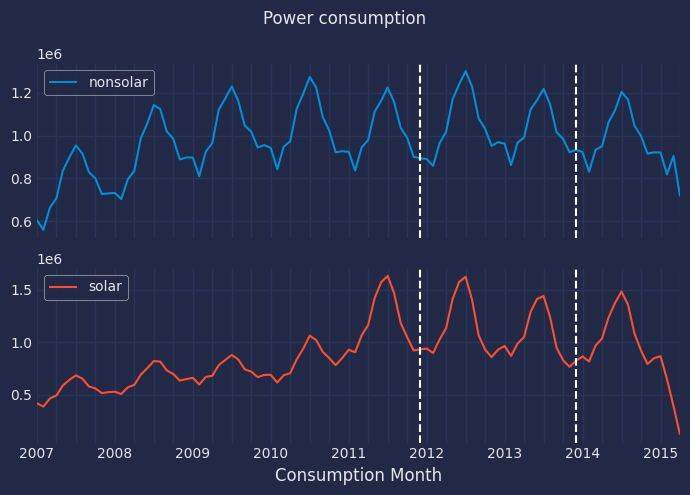

In [42]:

# Plot time series
# ======================================================================================
set_dark_theme()
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
consumption_data.iloc[:, :].plot(
    legend   = True,
    subplots = True, 
    title    = 'Power consumption',
    ax       = axs, 
)
for ax in axs:
    ax.axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1.5)
    ax.axvline(pd.to_datetime(end_val) , color='white', linestyle='--', linewidth=1.5)
fig.tight_layout()
plt.show()

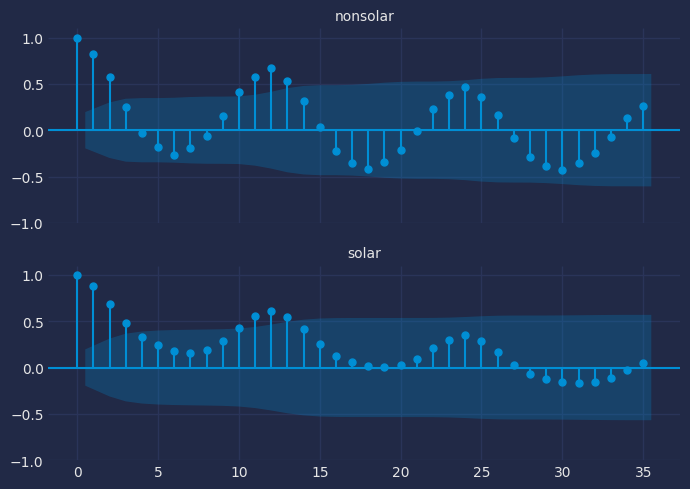

In [43]:
# Autocorrelation plot
# ======================================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)
axes = axes.flat
for i, col in enumerate(consumption_data.columns):
    plot_acf(consumption_data[col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}', fontsize=10)
fig.tight_layout()
plt.show()

In [44]:
# Train and backtest a model for both house types: ForecasterAutoregMultiSeries
# ======================================================================================
house_type = list(consumption_data.columns)

# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=823),
                    lags               = 8,
                    encoding           = 'ordinal',
                    transformer_series = StandardScaler(),
                )
print(type(forecaster_ms).__name__)


ForecasterAutoregMultiSeries


In [45]:
data_train.asfreq("MS")
forecaster_ms.fit(series=data_train[['solar', 'nonsolar']])


/opt/conda/lib/python3.10/site-packages/skforecast/utils/utils.py:1058: UserWarning: Series has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [46]:
# Predict and predict_interval
# ==============================================================================
steps = 6

# Predictions
predictions = forecaster_ms.predict(steps=steps)
display(predictions.head(6))

# Interval predictions
predictions_interval = forecaster_ms.predict_interval(steps=steps)
display(predictions_interval.head(6))

,nonsolar,solar
60,857287.130933,9.119755e+05
61,864828.190189,9.119755e+05
62,903856.556496,9.119755e+05
63,907887.084076,9.725643e+05
64,942668.832394,1.137648e+06
65,982217.827980,1.316840e+06


,nonsolar,nonsolar_lower_bound,nonsolar_upper_bound,solar,solar_lower_bound,solar_upper_bound
60,857287.130933,795047.933523,9.191526e+05,9.119755e+05,820198.686506,1.032291e+06
61,864828.190189,802122.678335,9.270012e+05,9.119755e+05,769936.462651,1.100399e+06
62,903856.556496,833502.965016,1.036171e+06,9.119755e+05,728714.540464,1.127407e+06
63,907887.084076,820554.400748,1.106324e+06,9.725643e+05,741956.846882,1.244952e+06
64,942668.832394,824615.540225,1.186285e+06,1.137648e+06,853536.088411,1.371476e+06
65,982217.827980,839129.811194,1.266990e+06,1.316840e+06,989877.895865,1.396703e+06


### Backtesting
In time series forecasting, the process of backtesting consists of evaluating the performance of a predictive model by applying it retrospectively to historical data. Therefore, it is a special type of cross-validation applied to the previous period(s).

The purpose of backtesting is to evaluate the accuracy and effectiveness of a model and identify any potential issues or areas of improvement. By testing the model on historical data, one can assess how well it performs on data that it has not seen before.

Backtesting without refit is a strategy where the model is trained only once and used sequentially without updating it, following the temporal order of the data. This approach is advantageous as it is much faster than other methods that require retraining the model each time. However, the model may lose its predictive power over time as it does not incorporate the latest information available.

In [47]:
# Backtesting forecaster for all items
consumption_data = consumption_data.asfreq("MS")
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = consumption_data,
                                       levels             = house_type,
                                       steps              = 4,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(data_train) + len(data_val),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True 
                                    )
# Results
display(multi_series_mae.head())
print('')
display(predictions_ms.head())

  0%|          | 0/4 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,nonsolar,59379.606227
1,solar,233629.224838


,nonsolar,solar
2014-01-01,9.124925e+05,7.700901e+05
2014-02-01,8.571690e+05,7.403813e+05
2014-03-01,9.891224e+05,8.577212e+05
2014-04-01,1.060536e+06,1.079653e+06
2014-05-01,1.018900e+06,1.188282e+06


### Individual forecaster for each house type



In [48]:
house_types = ['solar','nonsolar']
mae_values = []
predictions = {}

for i, house_type in enumerate(tqdm(consumption_data.columns)):
    # Define forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=8523),
                     lags          = 8,
                     transformer_y = StandardScaler()
                 )
    # Backtesting forecaster
    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = consumption_data[house_type],
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 4,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )

    mae_values.append(metric)
    predictions[house_type] = preds

# Results
uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = house_types,
                     name  = 'uni_series_mae'
                 )
uni_series_mae.head(10)

  0%|          | 0/2 [00:00<?, ?it/s]

solar        75655.753211
nonsolar    214234.176740
Name: uni_series_mae, dtype: float64

### Comparison

In [52]:
# Difference of backtesting metric for each item
# ======================================================================================
multi_series_mae = multi_series_mae.set_index('levels')
multi_series_mae.columns = ['multi_series_mae']

results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d'])

,uni_series_mae,multi_series_mae,improvement,improvement_(%)
solar,75655.750000,233629.220000,-157973.470000,-208.810000
nonsolar,214234.180000,59379.610000,154854.570000,72.280000


### Forecasting for each customer - Solar

In [76]:
customer_consumption_data = pd.pivot_table(
           data    = solar_consumption,
           values  = 'consumption',
           index   = 'Consumption Month',
           columns = 'Customer ID'
       )
customer_consumption_data = customer_consumption_data.asfreq('MS')
customer_consumption_data.head()

Customer ID,1,2,3,4,6,7,8,10,11,12,...,2756,2760,2761,2762,2763,2764,2765,2766,2767,2768
Consumption Month,,,,,,,,,,,,,,,,,,,,,
2007-01-01,168.073,175.188,118.287,138.152,347.032,561.184,307.893,128.904,0.0,NaN,...,441.292,729.226,22.595,15.344,216.101,914.976,10.029,3.756,4.606,164.032
2007-02-01,159.667,138.478,93.906,144.273,304.376,453.363,275.660,115.111,0.0,NaN,...,398.585,850.300,87.556,214.826,456.554,867.846,9.059,37.969,37.334,148.159
2007-03-01,176.774,153.315,103.967,166.923,337.371,501.938,302.855,127.444,0.0,NaN,...,349.380,941.403,121.718,548.806,601.924,964.831,10.029,42.038,304.948,164.032
2007-04-01,182.439,192.666,132.050,161.538,337.582,485.160,293.086,144.266,0.0,NaN,...,312.165,1076.208,117.792,635.773,582.507,1049.784,13.864,55.183,565.058,534.224
2007-05-01,235.507,234.090,158.108,218.116,348.835,500.421,428.399,151.477,0.0,NaN,...,324.794,1225.866,53.178,656.966,938.717,1084.776,16.809,79.505,716.728,579.745


In [77]:
customer_consumption_data.fillna(value = 0, axis = 'columns', inplace = True)
customer_consumption_data.head()

Customer ID,1,2,3,4,6,7,8,10,11,12,...,2756,2760,2761,2762,2763,2764,2765,2766,2767,2768
Consumption Month,,,,,,,,,,,,,,,,,,,,,
2007-01-01,168.073,175.188,118.287,138.152,347.032,561.184,307.893,128.904,0.0,0.0,...,441.292,729.226,22.595,15.344,216.101,914.976,10.029,3.756,4.606,164.032
2007-02-01,159.667,138.478,93.906,144.273,304.376,453.363,275.660,115.111,0.0,0.0,...,398.585,850.300,87.556,214.826,456.554,867.846,9.059,37.969,37.334,148.159
2007-03-01,176.774,153.315,103.967,166.923,337.371,501.938,302.855,127.444,0.0,0.0,...,349.380,941.403,121.718,548.806,601.924,964.831,10.029,42.038,304.948,164.032
2007-04-01,182.439,192.666,132.050,161.538,337.582,485.160,293.086,144.266,0.0,0.0,...,312.165,1076.208,117.792,635.773,582.507,1049.784,13.864,55.183,565.058,534.224
2007-05-01,235.507,234.090,158.108,218.116,348.835,500.421,428.399,151.477,0.0,0.0,...,324.794,1225.866,53.178,656.966,938.717,1084.776,16.809,79.505,716.728,579.745


In [78]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2011-12-01 23:59:00'
end_val = '2013-12-01 23:59:00'

customer_data_train = customer_consumption_data.loc[:end_train, :].copy()
customer_data_val   = customer_consumption_data.loc[end_train:end_val, :].copy()
customer_data_test  = customer_consumption_data.loc[end_val:, :].copy()
print(f"Train dates      : {customer_data_train.index.min()} --- {customer_data_train.index.max()}  (n={len(customer_data_train)})")
print(f"Validation dates : {customer_data_val.index.min()} --- {customer_data_val.index.max()}  (n={len(customer_data_val)})")
print(f"Test dates       : {customer_data_test.index.min()} --- {customer_data_test.index.max()}  (n={len(customer_data_test)})")

Train dates      : 2007-01-01 00:00:00 --- 2011-12-01 00:00:00  (n=60)
Validation dates : 2012-01-01 00:00:00 --- 2013-12-01 00:00:00  (n=24)
Test dates       : 2014-01-01 00:00:00 --- 2015-04-01 00:00:00  (n=16)


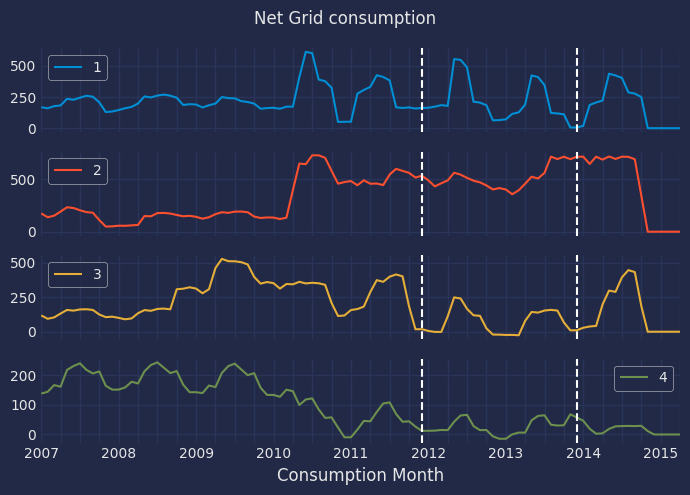

In [79]:
# Plot time series
# ======================================================================================
set_dark_theme()
fig, axs = plt.subplots(4, 1, figsize=(7, 5), sharex=True)
customer_consumption_data.iloc[:, :4].plot(
    legend   = True,
    subplots = True, 
    title    = 'Net Grid consumption',
    ax       = axs, 
)
for ax in axs:
    ax.axvline(pd.to_datetime(end_train) , color='white', linestyle='--', linewidth=1.5)
    ax.axvline(pd.to_datetime(end_val) , color='white', linestyle='--', linewidth=1.5)
fig.tight_layout()
plt.show()

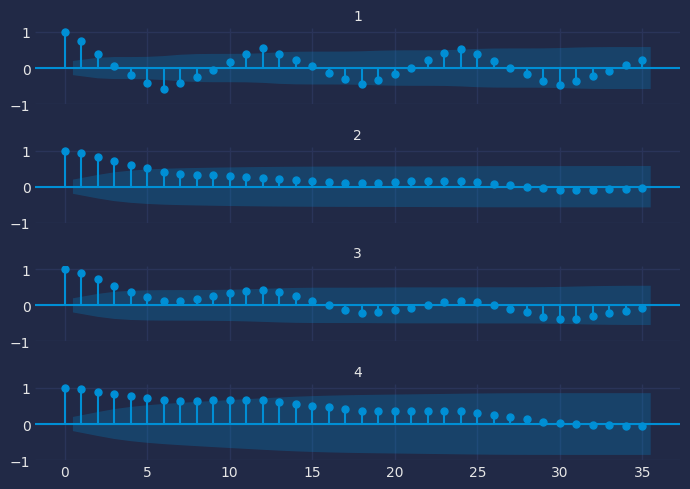

In [80]:
# Autocorrelation plot
# ======================================================================================
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 5), sharex=True)
axes = axes.flat
for i, col in enumerate(customer_consumption_data.columns[:4]):
    plot_acf(customer_consumption_data[col], ax=axes[i], lags=7*5)
    axes[i].set_ylim(-1, 1.1)
    axes[i].set_title(f'{col}', fontsize=10)
fig.tight_layout()
plt.show()

In [71]:
customer_consumption_data.head()

Customer ID,1,2,3,4,6,7,8,10,11,12,...,2756,2760,2761,2762,2763,2764,2765,2766,2767,2768
Consumption Month,,,,,,,,,,,,,,,,,,,,,
2007-01-01,168.073,175.188,118.287,138.152,347.032,561.184,307.893,128.904,0.0,0.0,...,441.292,729.226,22.595,15.344,216.101,914.976,10.029,3.756,4.606,164.032
2007-02-01,159.667,138.478,93.906,144.273,304.376,453.363,275.660,115.111,0.0,0.0,...,398.585,850.300,87.556,214.826,456.554,867.846,9.059,37.969,37.334,148.159
2007-03-01,176.774,153.315,103.967,166.923,337.371,501.938,302.855,127.444,0.0,0.0,...,349.380,941.403,121.718,548.806,601.924,964.831,10.029,42.038,304.948,164.032
2007-04-01,182.439,192.666,132.050,161.538,337.582,485.160,293.086,144.266,0.0,0.0,...,312.165,1076.208,117.792,635.773,582.507,1049.784,13.864,55.183,565.058,534.224
2007-05-01,235.507,234.090,158.108,218.116,348.835,500.421,428.399,151.477,0.0,0.0,...,324.794,1225.866,53.178,656.966,938.717,1084.776,16.809,79.505,716.728,579.745


#### Individual forecaster - Customer

In [ ]:
# Train and backtest a model for each item: ForecasterAutoreg
# ======================================================================================

customers = []
mae_values = []
predictions = {}

for i, customer in enumerate(tqdm(customer_consumption_data.columns)):
    # Define forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=8523),
                     lags          = 8,
                     transformer_y = StandardScaler()
                 )
    # Backtesting forecaster
    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = customer_consumption_data[customer],
                        initial_train_size = len(customer_data_train) + len(customer_data_val),
                        steps              = 4,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )
    customers.append(customer)
    mae_values.append(metric)
    predictions[customer] = preds

# Results
uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = customers,
                     name  = 'uni_series_mae'
                 )

  0%|          | 0/2624 [00:00<?, ?it/s]

#### Global Forecaster - Customer

In [84]:
# Train and backtest a model for all items: ForecasterAutoregMultiSeries
# ======================================================================================
customers = list(customer_consumption_data.columns)

# Define forecaster
forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = HistGradientBoostingRegressor(random_state=8523),
                    lags               = 8,
                    encoding           = 'ordinal',
                    transformer_series = StandardScaler(),
                )
# Backtesting forecaster for all items
multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = customer_consumption_data,
                                       levels             = customers,
                                       steps              = 4,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(customer_data_train) + len(customer_data_val),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True 
                                    )
# Results
display(multi_series_mae.head(3))
print('')
display(predictions_ms.head(3))

  0%|          | 0/4 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,1,117.037985
1,2,195.598353
2,3,97.780814


,1,2,3,4,6,7,8,10,11,12,...,2756,2760,2761,2762,2763,2764,2765,2766,2767,2768
2014-01-01,35.770589,637.624008,19.117568,55.392036,648.937188,176.835729,857.508599,167.597065,144.687928,415.591038,...,-24.990773,-6.663024,372.801412,584.197240,83.914400,521.024821,166.086309,129.751783,244.818819,-71.069278
2014-02-01,137.123004,544.723609,33.707469,75.561851,675.066848,253.102918,990.043413,172.261806,243.762586,407.819708,...,-3.200849,122.683061,540.659286,591.236138,237.507493,472.363173,196.273483,191.778011,312.717651,-45.153086
2014-03-01,154.794153,516.452855,34.779571,84.870214,710.337139,294.882782,1081.306991,180.722442,291.735720,409.170145,...,57.179957,221.053037,635.357172,621.575720,316.573986,442.184331,215.415720,210.591666,354.917950,-2.803880


#### Comparison

In [85]:
# Difference of backtesting metric for each item
# ======================================================================================
multi_series_mae = multi_series_mae.set_index('levels')
multi_series_mae.columns = ['multi_series_mae']

results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d'])

,uni_series_mae,multi_series_mae,improvement,improvement_(%)
1,115.530000,117.040000,-1.500000,-1.300000
2,197.670000,195.600000,2.070000,1.050000
3,133.990000,97.780000,36.210000,27.020000
4,20.350000,33.170000,-12.820000,-63.000000
6,270.330000,242.440000,27.890000,10.320000
7,129.340000,84.050000,45.290000,35.020000
8,436.090000,244.090000,191.990000,44.030000
10,189.520000,150.170000,39.340000,20.760000
11,96.560000,90.140000,6.430000,6.660000
12,191.470000,128.590000,62.870000,32.840000
